In [104]:
import numpy as np
import matplotlib.pyplot as plt
from hand_to_mouth import *
from copy import deepcopy

%load_ext autoreload
%autoreload 2

# %pip install EconModel
from Model import ReferenceDependenceClass
model = ReferenceDependenceClass()
model.par.full_sample_estimation = True
model.allocate()
model_new = deepcopy(model)

from estimation import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Estimating using the full sample** #
(using hazard rates from both before and after the reform)

# Model with reference dependence

In [105]:
est_par = ['gamma', 'sigma', 'N', 'cost1', 'cost2', 'type_shares1', 'welfare'] # Parameters to estimate
bounds = [(0, 50.0), (0.0, 5.0), (0,50), (0.0,model.par.cost2), (model.par.cost1,1000.0), (0.0,1.0), (0.0,model.par.b3)] # Bounds for the parameters

# NOT random initial guesses
########################################################################################
# theta0 = [0.06, 2, 15, 100.0, 300, 0.4, 90/675]  # Initial guesses
# est = method_simulated_moments(model,est_par,theta0,bounds,weight=False)

# print("Optimization Results:")
# print("---------------------")
# print(f'{"Parameter":<15} {"Estimate":<15}')
# for param, estimate in zip(est_par, est.x):
#     print(f'{param:<15} {estimate:>15.3f}')
# print(f'Objective:               {est.fun:.4f}')
# print(f'Number of iterations:    {est.nit}')
########################################################################################

# S: Hvorfor estimerer den ikke N, men accepterer bare initial guess?
# S: Bør vi løse problemet med initial guess ved at trække gættende fra en uniform fordeling som de gør i papiret?

np.random.seed(180615) # Same seed as the paper

for i in range(model.par.noSearchInits):
    theta0 = [np.random.uniform(model.par.lb_gam,model.par.ub_gam, size=None),
              np.random.uniform(model.par.lb_sig,model.par.ub_sig, size=None),
              np.random.uniform(model.par.lb_N,model.par.ub_N, size=None),
              np.random.uniform(model.par.lb_lsc,model.par.ub_lsc, size=None),
              np.random.uniform(model.par.lb_msc,model.par.ub_msc, size=None),
              np.random.uniform(model.par.lb_share,model.par.ub_share, size=None),
              np.random.uniform(model.par.lb_wel,model.par.ub_wel, size=None)]

    est_best = np.inf
    est = method_simulated_moments(model,est_par,theta0,bounds,weight=False)
    if est.fun < est_best:
        est_best = est.fun
        par = est.x
        nit = est.nit

print("Optimization             Results:")
print("---------------------")
print(f'{"Parameter":<15} {"Estimate":<15}')
for param, estimate in zip(est_par, par):
    print(f'{param:<15} {estimate:>15.3f}')
print(f'Objective:               {est_best:.4f}')
print(f'Number of iterations:    {nit}')

Optimization             Results:
---------------------
Parameter       Estimate       
gamma                     0.055
sigma                     2.501
N                        11.688
cost1                    92.800
cost2                   374.229
type_shares1              0.036
welfare                   0.048
Objective:               0.3107
Number of iterations:    32


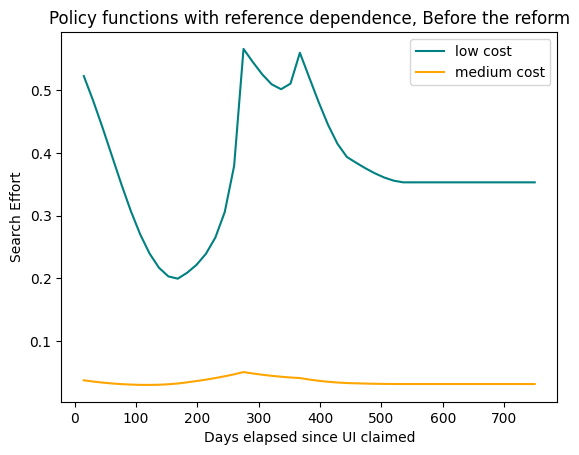

In [106]:
search_effort = solve_search_effort(model.par)
time = np.linspace(0, model.par.T, model.par.T)
plt.plot((time+1)*15, search_effort[0,:], label = 'low cost', color='teal') 
plt.plot((time+1)*15, search_effort[1,:], label = 'medium cost', color='orange') 
#plt.plot(time, search_effort[2,:], label = 'high' ) 
#plt.text(0.5, 0.96, '(Note that high cost is 0)', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Policy functions with reference dependence, Before the reform')
plt.legend()
plt.show()

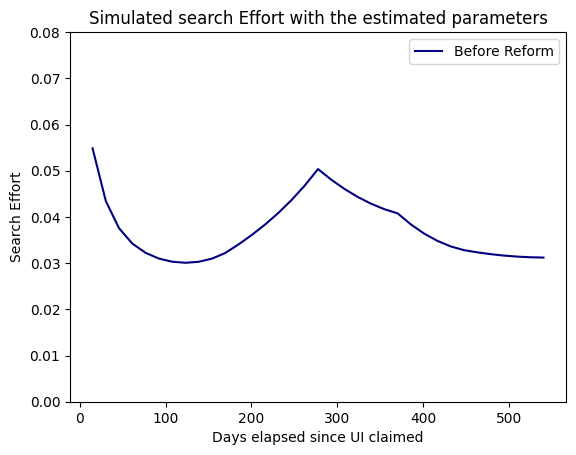

In [107]:
sim = sim_search_effort(model.par)
time = np.linspace(0, model.par.T_sim, model.par.T_sim)
plt.plot((time+1)*15, sim, color='navy', label='Before Reform') 
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.ylim(0.0, 0.08)
plt.legend()
plt.show()

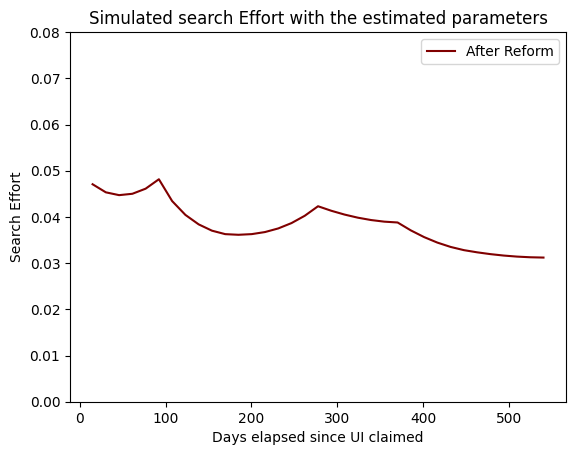

In [108]:
model.par.b1 = 342.0/675.0      # Value after reform
model.par.b2 = 171.0/675.0      # Value after reform

model.allocate()
s_forecast = model.solve()

true_data_outofsample = model.data.moments_after
true_data_insample = model.data.moments_before
mse_eta1_outofsample = np.mean((true_data_outofsample - s_forecast)**2)
mse_eta1_insample = np.mean((true_data_insample - sim)**2)

# Now plotting s_forecast
time = np.linspace(0, model.par.T_sim, model.par.T_sim)
plt.plot((time+1)*15, s_forecast, label='After Reform', color='maroon')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

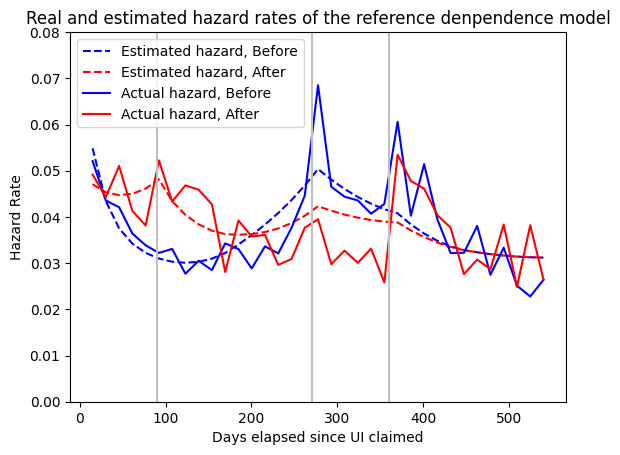

In [109]:
#Replicating figure 7(b) from the paper
after = model_new.data.moments_after
before = model_new.data.moments_before

time = np.linspace(0, model.par.T_sim, model.par.T_sim)
plt.plot((time+1)*15, sim, color='Blue', label='Estimated hazard, Before', linestyle='--')
plt.plot((time+1)*15, s_forecast, label='Estimated hazard, After', color='Red', linestyle='--')
plt.plot((time+1)*15, before, label='Actual hazard, Before', color='Blue')
plt.plot((time+1)*15, after, label='Actual hazard, After', color='Red')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
plt.title('Real and estimated hazard rates of the reference denpendence model')
plt.axvline(x=90, color='silver')
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

# Model with **NO** reference dependence (standard model)

In [110]:
# model_new = deepcopy(model)

model_new.par.eta = 0.0     # Removes reference dependence
# model_new.par.full_sample_estimation = True
model_new.allocate()

est_par = ['gamma', 'cost1', 'cost2', 'cost3', 'type_shares1', 'type_shares3', 'Welfare'] # Parameters to estimate
# theta0 = [0.9, 84, 242, 310, 0.4, 0, 0.1] # Initial guesses
bounds = [(0, 50.0), (0.0, model_new.par.cost2), (model_new.par.cost1,model_new.par.cost3), (model_new.par.cost2,700.0), (0,1), (0,1), (0,model.par.b3)] # Bounds for the parameters

# est = method_simulated_moments(model_new, est_par,theta0,bounds,weight=False)

# print("Optimization Results:")
# print("---------------------")
# print(f'{"Parameter":<15} {"Estimate":<15}')
# for param, estimate in zip(est_par, est.x):
#     print(f'{param:<15} {estimate:>15.3f}')
# print(f'Objective:               {est.fun:.4f}')
# print(f'Number of iterations:    {est.nit}')


np.random.seed(180615) # Same seed as the paper

for i in range(model.par.noSearchInits):
    theta0 = [np.random.uniform(model.par.lb_gam,model.par.ub_gam, size=None),
              np.random.uniform(model.par.lb_lsc,model.par.ub_lsc, size=None),
              np.random.uniform(model.par.lb_msc,model.par.ub_msc, size=None),
              np.random.uniform(model.par.lb_hsc,model.par.ub_hsc, size=None),
              np.random.uniform(model.par.lb_share,model.par.ub_share, size=None),
              np.random.uniform(model.par.lb_share,model.par.ub_share, size=None),
              np.random.uniform(model.par.lb_wel,model.par.ub_wel, size=None)]

    est_best = np.inf
    est = method_simulated_moments(model,est_par,theta0,bounds,weight=False)
    if est.fun < est_best:
        est_best = est.fun
        par = est.x
        nit = est.nit

print("Optimization Results:")
print("---------------------")
print(f'{"Parameter":<15} {"Estimate":<15}')
for param, estimate in zip(est_par, par):
    print(f'{param:<15} {estimate:>15.3f}')
print(f'Objective:               {est_best:.4f}')
print(f'Number of iterations:    {nit}')

KeyboardInterrupt: 

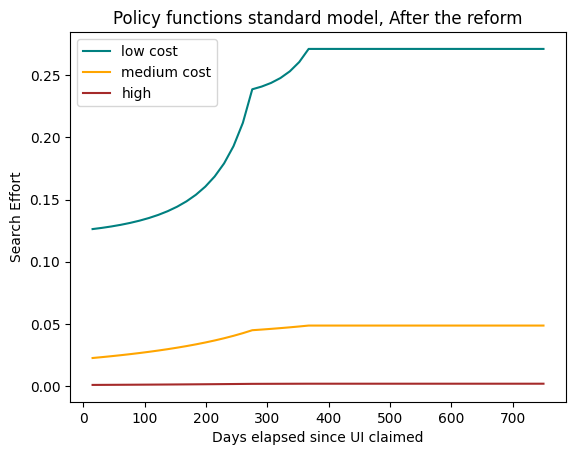

In [ ]:
search_effort_new = solve_search_effort(model_new.par)
time = np.linspace(0, model_new.par.T, model_new.par.T)
plt.plot((time+1)*15, search_effort_new[0,:], label = 'low cost', color='teal') 
plt.plot((time+1)*15, search_effort_new[1,:], label = 'medium cost', color='orange') 
plt.plot((time+1)*15, search_effort_new[2,:], label = 'high', color='brown' ) 
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Policy functions standard model, After the reform')
plt.legend()
plt.show()

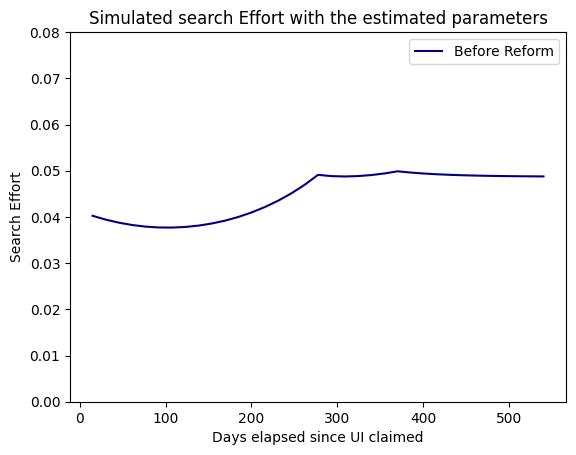

In [ ]:
sim_new = sim_search_effort(model_new.par)
time = np.linspace(0, model_new.par.T_sim, model_new.par.T_sim)
plt.plot((time+1)*15, sim_new, label='Before Reform', color='navy') 
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()


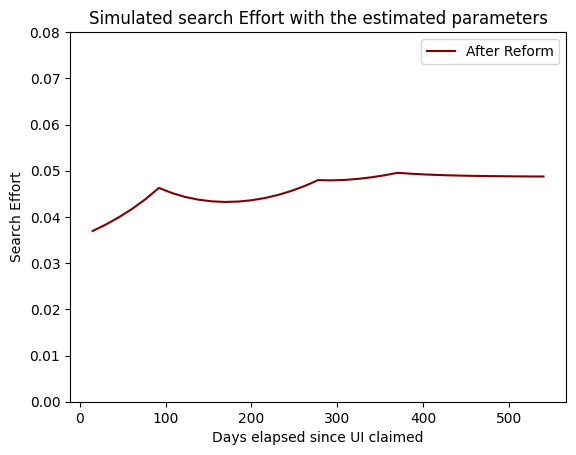

In [ ]:
model_new.par.b1 = 342.0/675.0      # Value after reform
model_new.par.b2 = 171.0/675.0      # Value after reform

model_new.allocate()
s_forecast_new = model_new.solve()


# Now plotting s_forecast
time = np.linspace(0, model_new.par.T_sim, model_new.par.T_sim)
plt.plot((time+1)*15, s_forecast_new, label='After Reform', color='maroon')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Search Effort')
plt.title('Simulated search Effort with the estimated parameters')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

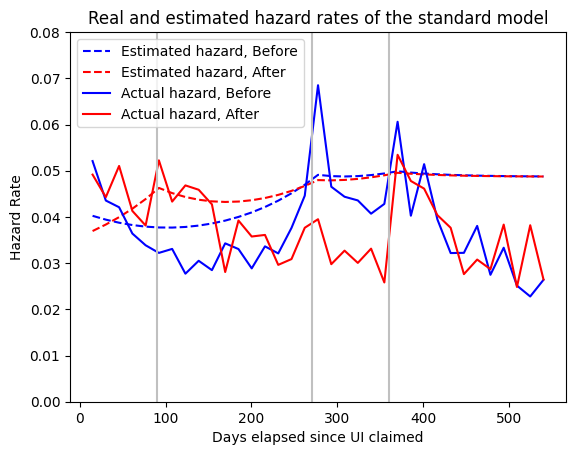

In [ ]:
#Replicating figure 7(a) from the paper

time = np.linspace(0, model_new.par.T_sim, model_new.par.T_sim)
plt.plot((time+1)*15, sim_new, color='Blue', label='Estimated hazard, Before', linestyle='--')
plt.plot((time+1)*15, s_forecast_new, label='Estimated hazard, After', color='Red', linestyle='--')
plt.plot((time+1)*15, before, label='Actual hazard, Before', color='Blue')
plt.plot((time+1)*15, after, label='Actual hazard, After', color='Red')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
plt.title('Real and estimated hazard rates of the standard model')
plt.axvline(x=90, color='silver')
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.legend()
plt.ylim(0.0, 0.08)
plt.show()

# **Comparison of the standard model and reference dependence**
### Through the Mean Square Error

In [ ]:
true_data_outofsample = model_new.data.moments_after
true_data_insample = model_new.data.moments_before

# Get the mean square errors
mse_eta0_outofsample = np.mean((true_data_outofsample - s_forecast_new)**2)
mse_eta0_insample = np.mean((true_data_insample - sim_new)**2)

# Comparison out of sample
comparison1 = "smaller" if mse_eta1_outofsample < mse_eta0_outofsample else "bigger" if mse_eta1_outofsample > mse_eta0_outofsample else "equal"
comparison2 = "WITH reference dependence" if mse_eta1_outofsample < mse_eta0_outofsample else "WITHOUT reference dependence" 

# Comparison in sample
comparison3 = "smaller" if mse_eta1_insample < mse_eta0_insample else "bigger" if mse_eta1_insample > mse_eta0_insample else "equal"
comparison4 = "WITH reference dependence" if mse_eta1_insample < mse_eta0_insample else "WITHOUT reference dependence"


print("Before the reform: ")
print("-" * 100)
print(f"The mean square error from the model \033[1mwith\033[0m reference dependence is {mse_eta1_insample}")
print(f"The mean square error from the model \033[1mwithout\033[0m reference dependence is {mse_eta0_insample}")
print(f"The mean square error for the model \033[1mwith\033[0m reference dependence is \033[1m{comparison3}\033[0m than the model without.")
print(f"Best model: \033[1m{comparison4}\033[0m.")
print("-" * 100)



print("After the reform:")
print("-" * 100)
print(f"The mean square error from the model \033[1mwith\033[0m reference dependence is {mse_eta1_outofsample}")
print(f"The mean square error from the model \033[1mwithout\033[0m reference dependence is {mse_eta0_outofsample}")
print(f"The mean square error for the model \033[1mwith\033[0m reference dependence is \033[1m{comparison1}\033[0m than the model without.")
print(f"Best model: \033[1m{comparison2}\033[0m.")
print("-" * 100)

Before the reform: 
----------------------------------------------------------------------------------------------------
The mean square error from the model with reference dependence is 0.00013816936207194022
The mean square error from the model without reference dependence is 0.0001678550527532114
The mean square error for the model with reference dependence is smaller than the model without.
Best model: WITH reference dependence.
----------------------------------------------------------------------------------------------------
After the reform:
----------------------------------------------------------------------------------------------------
The mean square error from the model with reference dependence is 8.772274845118808e-05
The mean square error from the model without reference dependence is 0.00014371801147213624
The mean square error for the model with reference dependence is smaller than the model without.
Best model: WITH reference dependence.
---------------------------

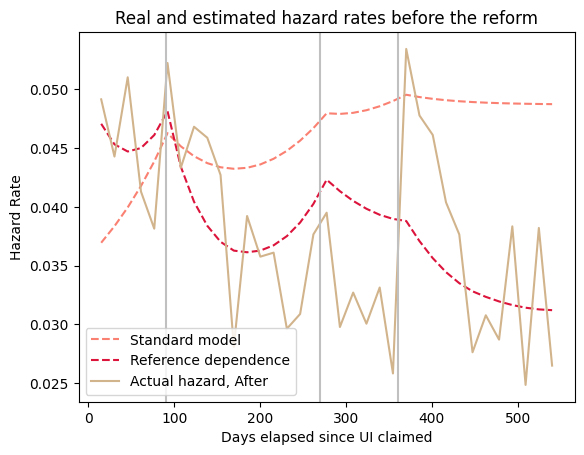

In [ ]:
after = model_new.data.moments_after

time = np.linspace(0, model_new.par.T_sim, model_new.par.T_sim)     # x-axis
plt.plot((time+1)*15, s_forecast_new, label='Standard model', color='salmon', linestyle='--')                     # Model with no reference dependence
plt.plot((time+1)*15, s_forecast, label='Reference dependence', color='crimson', linestyle='--')                         # Model with reference dependence
plt.plot((time+1)*15, after, label='Actual hazard, After', color='tan')                        # True data
# Make a vertical line at 90, 270 and 360
plt.axvline(x=90, color='silver')
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
plt.legend()
plt.title('Real and estimated hazard rates before the reform')
plt.show()

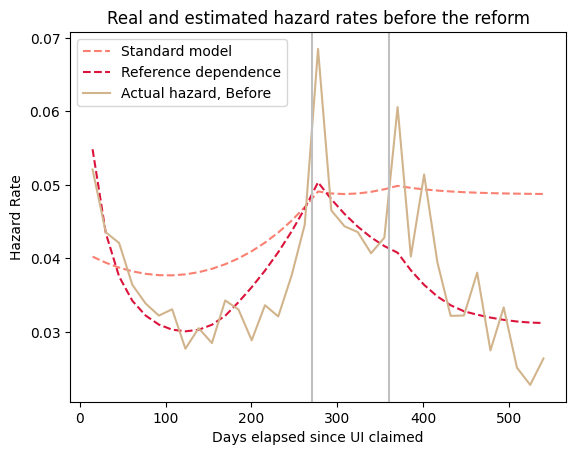

In [ ]:
before = model_new.data.moments_before

time = np.linspace(0, model_new.par.T_sim, model_new.par.T_sim)     # x-axis
plt.plot((time+1)*15, sim_new, label='Standard model', color='salmon', linestyle='--')                            # Model with no reference dependence
plt.plot((time+1)*15, sim, label='Reference dependence', color='crimson', linestyle='--')                                # Model with reference dependence
plt.plot((time+1)*15, before, label='Actual hazard, Before', color='tan')                           # True data
plt.axvline(x=270, color='silver')
plt.axvline(x=360, color='silver')
plt.xlabel('Days elapsed since UI claimed')
plt.ylabel('Hazard Rate')
plt.legend()
plt.title('Real and estimated hazard rates before the reform')
plt.show()